# Curve fitting resources

- https://www.youtube.com/watch?v=Jl-Ye38qkRc
- https://www.youtube.com/watch?v=4vryPwLtjIY

### TODO
- Try classification

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from glob import glob

from keras.models import load_model

import matplotlib
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Make all python scripts available in the path
import sys
sys.path.append('../')

In [7]:
import lrn_crv

In [8]:
filepath = Path(os.getcwd())
filepath

PosixPath('/vol/ml/apartin/projects/LearningCurves/notebooks')

# Utils

In [21]:
def plot_all_metrics_from_runs(runs, metrics='all', title:str=None, figsize:tuple=(20,18), save:bool=False,
                               xtick_scale:str='log2', ytick_scale:str='log2'):
    """ Plot all metrics from multiple runs for comparison. """
    
    if metrics=='all':
        tmp = pd.read_csv(runs[0]['dir']/'lrn_crv_scores.csv')
        metrics = tmp['metric'].unique()

    colors = ['b', 'r', 'k', 'c', 'm', 'g']
    fontsize = 14

    ncols = 2
    nrows = int(np.ceil(len(set(metrics))/ncols))
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    ax = ax.ravel()

    # Iterate over metrics
    for i, metric_name in enumerate(metrics):

        for j, r in enumerate(runs): 
            df = pd.read_csv(r['dir']/'lrn_crv_scores.csv')
            cvf = len([c for c in df.columns.tolist() if c[0]=='f']) # get the number of cv_folds

            dfm = df[df['metric']==metric_name].reset_index(drop=True)  # scores for a specific metric 

            tr_sizes  = dfm['tr_size'].unique()
            # te_scores = dfm.loc[dfm['tr_set']==False, dfm.columns[-cvf:]]
            te_scores = dfm.loc[dfm['set']=='te', dfm.columns[-cvf:]]

            te_scores_mean = np.mean(te_scores, axis=1)
            te_scores_std  = np.std(te_scores, axis=1)

            # --------------------------------------
            # Plot learning curve
            # --------------------------------------
            # linestype = dd[ runs[k][0].split('_')[-1] ]
            # ax[i].plot(tr_sizes, te_scores_mean, marker='.', linestyle=linestype, color=colors[j], label=r['name'])
            ax[i].plot(tr_sizes, te_scores_mean, marker='.', linestyle='--', color=colors[j], label=r['name'])
            ax[i].fill_between(tr_sizes, te_scores_mean - te_scores_std, te_scores_mean + te_scores_std, alpha=0.1, color=colors[j])

            basex, xlabel_scale = lrn_crv.scale_ticks_params(tick_scale=xtick_scale)
            basey, ylabel_scale = lrn_crv.scale_ticks_params(tick_scale=ytick_scale)

            ax[i].set_xlabel(f'Training Dataset Size ({xlabel_scale})', fontsize=fontsize)
            if 'log' in xlabel_scale.lower(): ax[i].set_xscale('log', basex=basex)

            ylabel = ' '.join(s.capitalize() for s in metric_name.split('_'))
            ax[i].set_ylabel(f'{ylabel} ({ylabel_scale})', fontsize=fontsize)
            if 'log' in ylabel_scale.lower(): ax[i].set_yscale('log', basey=basey)   


            # ax[i].set_title(f'Learning curve ({src_name})', fontsize=fontsize)
            ax[i].set_title(f'Learning Curve', fontsize=fontsize)
            ax[i].legend(loc='best', frameon=True)

        plt.tight_layout()
        ax[i].grid(True)

        # if save: plt.savefig( outdir/(src_name+'_'+metric_name+'.png') )
        if save: plt.savefig( outdir/(metric_name+'.png') )

# LGBM with diff lrn capacities

Here we compare LGBM models with differenet learning capacities. This can be achieved the following parameters:
- n_estimators

In [22]:
maindir = filepath / '../gdsc_trn/split_on_none'  # Results dir
# maindir = filepath / '../ctrp_trn/split_on_none'  # Results dir
# maindir = filepath / '../top6_trn/split_on_none'  # Results dir

lgb_reg_auc_dir1 = maindir / 'gdsc.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m18'
lgb_reg_auc_dir2 = maindir / 'gdsc.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m20'
runs = [{'name': 'LGBM 100 trees',  'dir': lgb_reg_auc_dir1},
        {'name': 'LGBM 1000 trees', 'dir': lgb_reg_auc_dir2}]

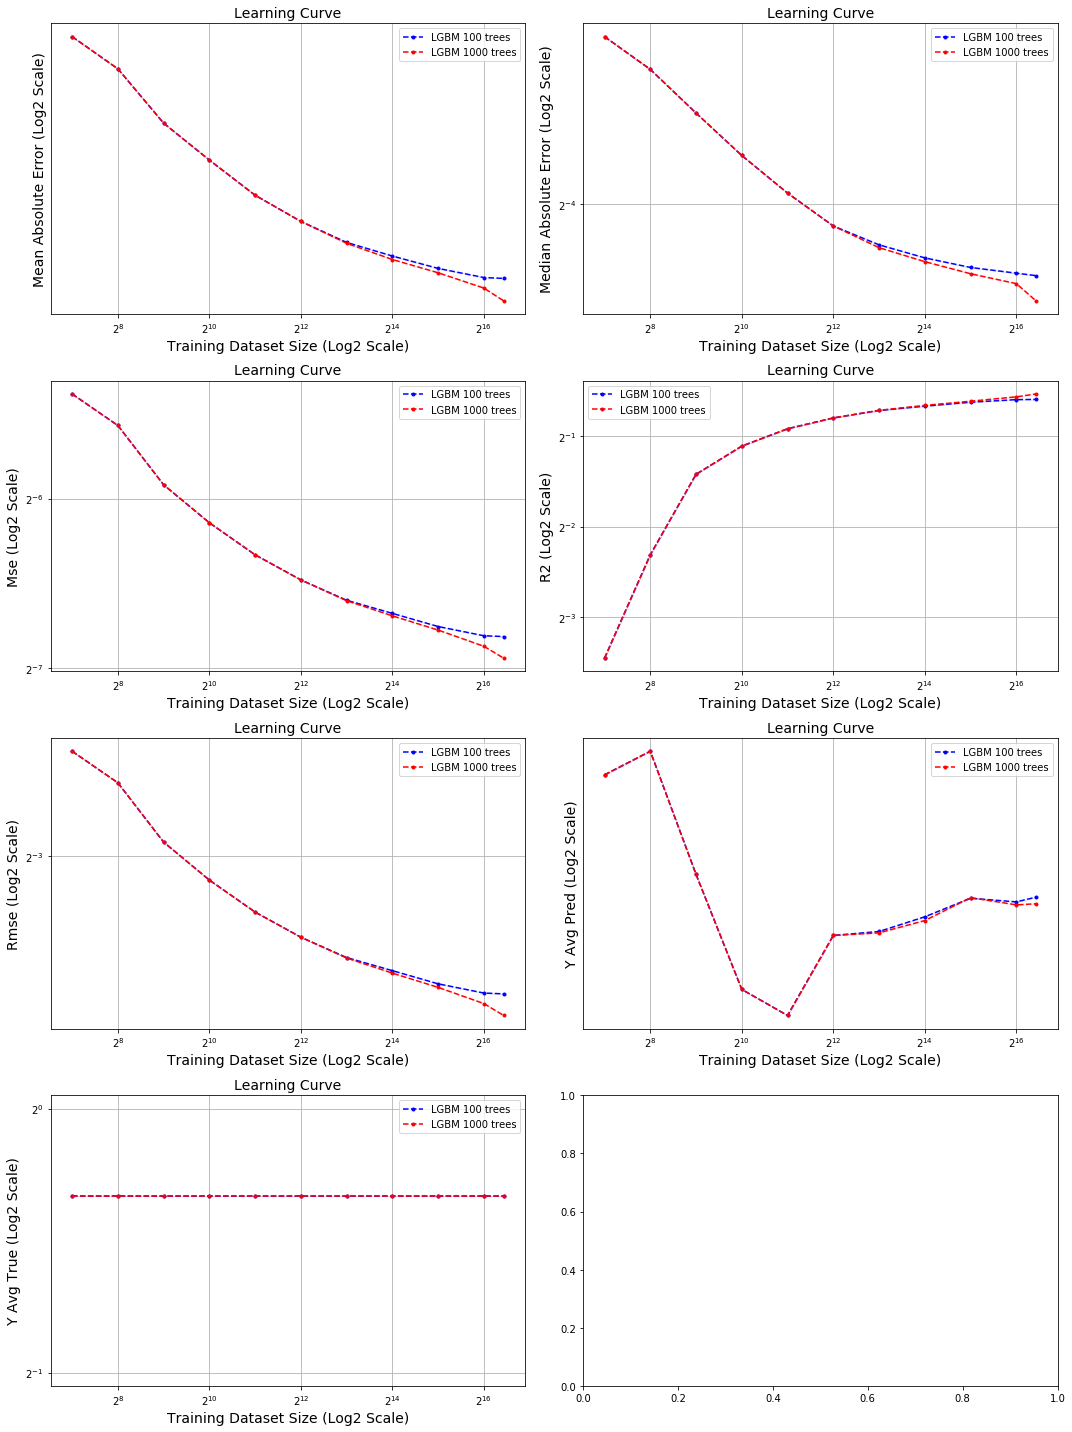

In [23]:
plot_all_metrics_from_runs(runs, metrics='all', title=None, figsize=(15,20), save=False)

# Old runs (the good results)

In [37]:
# def load_scores(run_dir, metric_name='mean_absolute_error', cv_folds=5):
#     """ Load scores from the scores master table into a format that is consistent
#     with the output of sklearn's function learning_curve(). That returns a list
#     of 3 arrays: data sizes, scores of training set, scores of val set.
#     """
#     scores_df = pd.read_csv(run_dir/'lrn_crv_scores.csv')
#     df = scores_df.loc[scores_df['tr_set']==False] # only val scores
    
#     data_sizes = sorted(df['tr_size'].unique())
#     aa = df[df['metric']==metric_name].reset_index(drop=True)
#     aa.sort_values('tr_size', inplace=True)

#     tr = aa[aa['tr_set']==True]
#     vl = aa[aa['tr_set']==False]

#     tr = tr.iloc[:, -cv_folds:]
#     vl = vl.iloc[:, -cv_folds:]

#     rslt = []
#     rslt.append(data_sizes)
#     rslt.append(tr.values if tr.values.shape[0]>0 else None)
#     rslt.append(vl.values if vl.values.shape[0]>0 else None)

#     return rslt, scores_df

# def get_xy(scores, metric_name='mean_absolute_error'):
#     """ Get x and y from scores (for specific run). """
#     dd = scores
#     dd = dd[dd['metric']==metric_name]
#     dd = dd[dd['tr_set']==False]
#     dd.reset_index(drop=True, inplace=True)
#     dd.drop(columns=['metric', 'tr_set'], inplace=True)
    
#     x = dd.tr_size.values
#     y = dd.iloc[:,1:].mean(axis=1).values
#     return x, y

# def fit_pwr_multi_runs(runs, metric_name='mean_absolute_error', shard_min_idx=0, cv_folds=1):
#     prms = []
#     for i, r in enumerate(runs):
#         rslt, scores_df = load_scores(r['dir'], metric_name=metric_name, cv_folds=cv_folds)
#         rslt[0], rslt[2] = rslt[0][shard_min_idx:], rslt[2][shard_min_idx:]
#         x, y = get_xy(scores_df, metric_name=metric_name)
#         x, y = x[shard_min_idx:], y[shard_min_idx:]

#         if i == 0: ax = None
#         ax, pwr_law_params = lrn_crv.plot_lrn_crv_power_law(x, y, plot_fit=True, metric_name=metric_name,
#                                 xtick_scale='log2', ytick_scale='log2',
#                                 xlim=None, ylim=None, title=None, figsize=(7,5),
#                                 label=r['name'], ax=ax)

#         prms.append( (r['name'], pwr_law_params) ) # aggregate params
#     return prms

[('LGBM Reg',
  {'alpha': 3.97374575083725,
   'beta': -0.6559491764754402,
   'gamma': 0.07040232956708603}),
 ('NN model0',
  {'alpha': 1.4911796972605114,
   'beta': -0.38070831300161717,
   'gamma': 0.05639449303659778}),
 ('NN model1',
  {'alpha': 40.75466797958667,
   'beta': -0.6790246037346926,
   'gamma': 0.05864713070929599})]

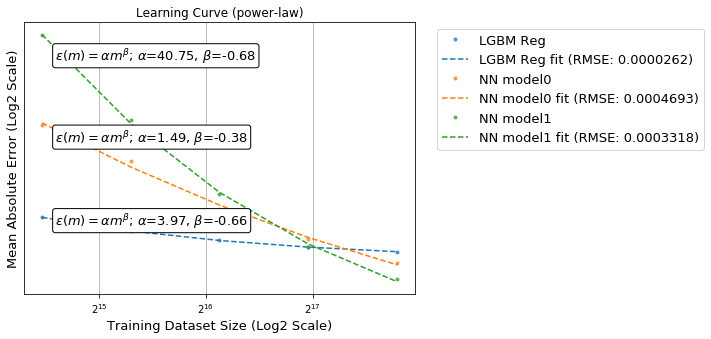

In [40]:
# maindir = filepath / '../../pilot1/out/lrn_crv'  # Results dir
# lgb_reg_dir       = maindir / 'top6.lgb_reg.cvf5.rna.dsc.AUC1_2019-6-20_h15-m29'
# nn_model0_sgd_dir = maindir / 'top6.nn_model0.sgd.cvf5.rna.dsc.AUC1_2019-6-21_h23-m20'
# nn_model1_sgd_dir = maindir / 'top6.nn_model1.sgd.cvf5.rna.dsc.AUC1_2019-6-22_h22-m44'

# src_name == 'top6'
# runs = [{'name': 'LGBM Reg',  'dir': lgb_reg_dir},
#         {'name': 'NN model0', 'dir': nn_model0_sgd_dir},
#         {'name': 'NN model1', 'dir': nn_model1_sgd_dir}]

# prms = fit_pwr_multi_runs(runs, metric_name='mean_absolute_error', shard_min_idx=0, cv_folds=1)
# prms

In [36]:
# plot_all_metrics_from_runs(runs, metrics='all', title=None, figsize=(20,20), save=False,
#                            xtick_scale='log2', ytick_scale='log2')

# Recent Runs

In [73]:
def get_xy_(path, metric_name='mean_absolute_error', tr_set='te', shard_min_idx=0, cv_folds=1, ):
    scores = pd.read_csv(path/'lrn_crv_scores.csv') # load the scores file
    df = scores[scores['metric']==metric_name].reset_index(drop=True)     

    # tr, vl, te = df[df['set']=='tr'], df[df['set']=='vl'], df[df['set']=='te']
    # tr, vl, te = tr.iloc[:, -cv_folds:], vl.iloc[:, -cv_folds:], te.iloc[:, -cv_folds:]

    cols = ['tr_size'] + ['fold'+str(f+1) for f in range(cv_folds)]
    dd = df.loc[df['set']==tr_set, cols].sort_values('tr_size').reset_index(drop=True)

    x = dd.tr_size.values
    y = dd.iloc[:,1:].mean(axis=1).values # mean over folds        
    x, y = x[shard_min_idx:], y[shard_min_idx:]
    return x, y


def fit_pwr_multi_runs(runs, metric_name='mean_absolute_error', tr_set='te', cv_folds=1,
                       shard_min_idx=0, xtick_scale='log2', ytick_scale='log2'):
    prms = []
    for i, r in enumerate(runs):        
        x, y = get_xy_(path=r['dir'], metric_name=metric_name, cv_folds=cv_folds, tr_set=tr_set)
        
        if i == 0: ax = None
        ax, pwr_law_params = lrn_crv.plot_lrn_crv_power_law(
            x=x, y=y,
            plot_fit=True, metric_name=metric_name,
            xtick_scale=ytick_scale, ytick_scale=ytick_scale,
            marker='.', alpha=0.7,
            label=r['name'], ax=ax, figsize=(8,6),
            title='Learning Curves')        
        
        prms.append( (r['name'], pwr_law_params) ) # aggregate params
    return prms

In [74]:
maindir = filepath / '../gdsc_trn/split_on_none'  # Results dir
# maindir = filepath / '../ctrp_trn/split_on_none'  # Results dir
# maindir = filepath / '../top6_trn/split_on_none'  # Results dir

# lgb_reg_auc_dir1 = maindir / 'gdsc.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m18'
# lgb_reg_auc_dir2 = maindir / 'gdsc.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m20'
# runs = [{'name': 'LGBM 100 trees',  'dir': lgb_reg_auc_dir1},
#         {'name': 'LGBM 1000 trees', 'dir': lgb_reg_auc_dir2}]

# rf_reg_auc_dir1 = maindir / 'gdsc.rf_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m33'
# rf_reg_auc_dir2 = maindir / 'gdsc.rf_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m48'
# runs = [{'name': 'RF 100 trees',  'dir': rf_reg_auc_dir1},
#         {'name': 'RF 1000 trees', 'dir': rf_reg_auc_dir2}]

lgb_reg_auc_dir2 = maindir / 'gdsc.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m20'
rf_reg_auc_dir2 = maindir / 'gdsc.rf_reg.cvf1.GE.DD.AUC_2019-11-4_h10-m48'
nn_reg_auc_dir = maindir / 'gdsc.adam.nn_reg0.cvf1.GE.DD.AUC_2019-11-3_h14-m30'
nn_reg_auc_clr_dir = maindir / 'gdsc.sgd.trng1.nn_reg0.cvf1.GE.DD.AUC_2019-11-5_h15-m55'
runs = [{'name': 'LGBM 1000 trees', 'dir': lgb_reg_auc_dir2},
        {'name': 'RF 1000 trees', 'dir': rf_reg_auc_dir2},
        {'name': 'NN_REG0', 'dir': nn_reg_auc_dir},
        {'name': 'NN_REG0 clr', 'dir': nn_reg_auc_clr_dir}]

# nn_reg_auc_dir1 = maindir / 'gdsc.sgd.nn_reg0.cvf1.GE.DD.AUC_2019-11-3_h14-m35'
# nn_reg_auc_dir2 = maindir / 'gdsc.adam.nn_reg0.cvf1.GE.DD.AUC_2019-11-3_h14-m30'
# runs = [{'name': 'NN_REG0 SGD', 'dir': nn_reg_auc_dir1},
#         {'name': 'NN_REG0 ADAM', 'dir': nn_reg_auc_dir2}]

# lgb_reg_auc_dir = maindir / 'ctrp.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h16-m38'
# nn_reg_auc_dir = maindir / 'ctrp.sgd.nn_reg0.cvf1.GE.DD.AUC_2019-11-4_h13-m7'
# runs = [{'name': 'lgb_reg', 'dir': lgb_reg_auc_dir},
#         {'name': 'nn_reg0 sgd', 'dir': nn_reg_auc_dir}]

# nn_reg_auc_dir = maindir / 'top6.adam.nn_reg0.cvf1.GE.DD.AUC_2019-11-4_h14-m46'
# lgb_reg_auc_dir1 = maindir / 'top6.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h18-m10'
# lgb_reg_auc_dir2 = maindir / 'top6.lgb_reg.cvf1.GE.DD.AUC_2019-11-4_h18-m38'
# runs = [{'name': 'nn_reg',  'dir': nn_reg_auc_dir},
#         {'name': 'lgb_reg 100', 'dir': lgb_reg_auc_dir1},
#         {'name': 'lgb_reg 1000', 'dir': lgb_reg_auc_dir2}]

[('LGBM 1000 trees',
  {'alpha': 0.2886028798970439,
   'beta': -0.3191305163298389,
   'gamma': 0.05894354322579894}),
 ('RF 1000 trees',
  {'alpha': 0.2765072069525803,
   'beta': -0.3406713928205644,
   'gamma': 0.06383939303852129}),
 ('NN_REG0',
  {'alpha': 1.6682983120144332,
   'beta': -0.4081640085555951,
   'gamma': 0.04292638952517528}),
 ('NN_REG0 clr',
  {'alpha': 0.7613759487048214,
   'beta': -0.43742280072267964,
   'gamma': 0.06406998170653064})]

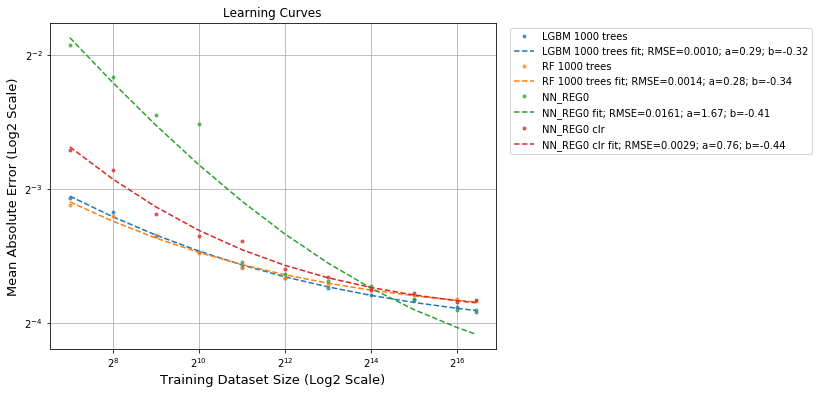

In [75]:
fit_pwr_multi_runs(runs, metric_name='mean_absolute_error', tr_set='te', shard_min_idx=4, cv_folds=1, xtick_scale='log2', ytick_scale='log2')